# Optimizer Comparison

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/sorix/blob/main/docs/learn/optimizers/05-Comparison.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/Mitchell-Mirano/sorix/blob/main/docs/learn/optimizers/05-Comparison.ipynb)
[![Open in Docs](https://img.shields.io/badge/Open%20in-Docs-blue?logo=readthedocs)](http://127.0.0.1:8000/sorix/learn/optimizers/05-Comparison)


Selecting the right optimizer is crucial for the success of a deep learning model. In this guide, we compare the convergence properties of the optimizers available in Sorix using a classic test problem: the **Rosenbrock function** (also known as the *Banana function*).

## The Rosenbrock Function

The Rosenbrock function is a non-convex function often used as a performance test for optimization algorithms. It is defined as:

$$
f(x, y) = (a - x)^2 + b(y - x^2)^2
$$

Typically, $a=1$ and $b=100$. The global minimum is at $(x, y) = (1, 1)$, located inside a long, narrow, parabolic-shaped flat valley. Finding the valley is easy, but converging to the global minimum is difficult for simple algorithms due to the flat landscape.


In [1]:
# Uncomment the next line and run this cell to install sorix
#!pip install 'sorix @ git+https://github.com/Mitchell-Mirano/sorix.git@main'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sorix import tensor
from sorix.optim import SGD, SGDMomentum, RMSprop, Adam

In [3]:
def optimize_banana(optimizer_class, lr, epochs=1000, **kwargs):
    # Initial position far from the minimum (1, 1)
    x_val = -2.0
    y_val = 2.0
    
    x = tensor([x_val], requires_grad=True)
    y = tensor([y_val], requires_grad=True)
    
    optimizer = optimizer_class([x, y], lr=lr, **kwargs)
    
    history = []
    for epoch in range(epochs):
        # f(x, y) = (1 - x)^2 + 100 * (y - x^2)^2
        loss = (tensor([1.0]) - x)**2 + tensor([100.0]) * (y - x**2)**2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record path
        history.append((float(x.data[0]), float(y.data[0]), float(loss.data[0])))
        
    return np.array(history)

# Hyperparameters
EPOCHS = 2000

print("Running optimizations...")
results = {
    "SGD (lr=0.001)": optimize_banana(SGD, lr=0.001, epochs=EPOCHS),
    "Momentum (lr=0.001)": optimize_banana(SGDMomentum, lr=0.001, momentum=0.9, epochs=EPOCHS),
    "RMSprop (lr=0.01)": optimize_banana(RMSprop, lr=0.01, epochs=EPOCHS),
    "Adam (lr=0.1)": optimize_banana(Adam, lr=0.1, epochs=EPOCHS)
}
print("Done!")

Running optimizations...


Done!


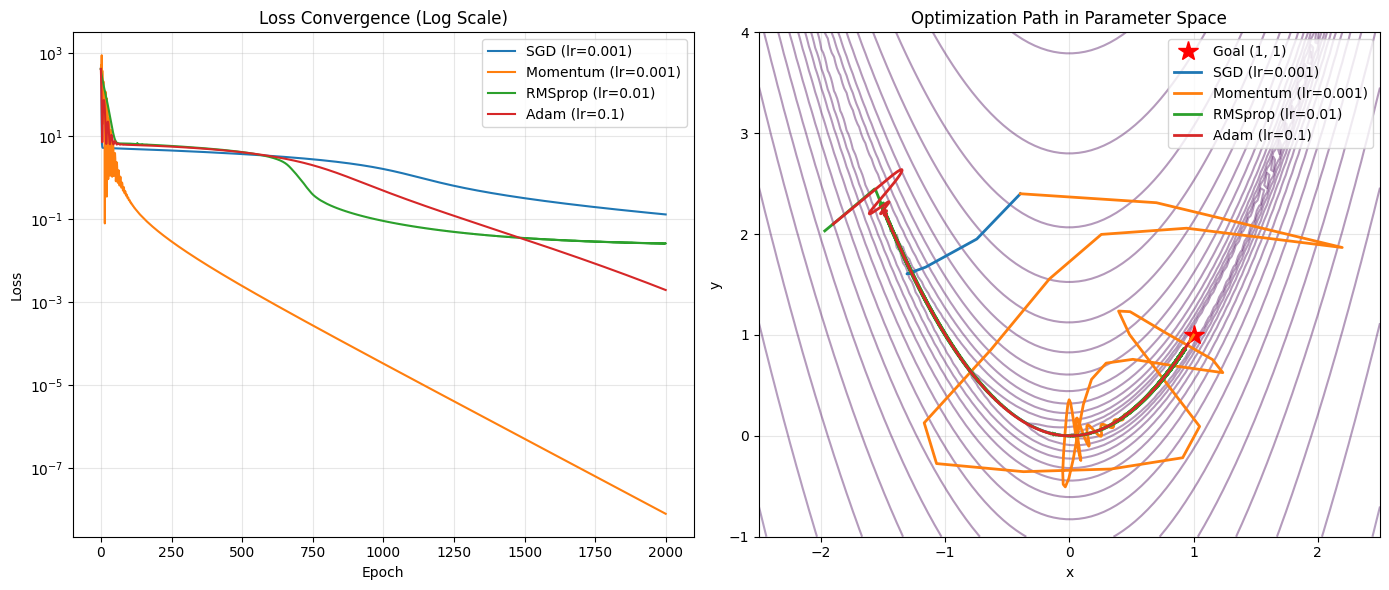

In [4]:
plt.figure(figsize=(14, 6))

# 1. Loss Convergence
plt.subplot(1, 2, 1)
for name, history in results.items():
    plt.plot(history[:, 2], label=name)
plt.yscale('log')
plt.title("Loss Convergence (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Parameter Space Path
plt.subplot(1, 2, 2)
X_grid, Y_grid = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-1, 4, 100))
Z_grid = (1 - X_grid)**2 + 100 * (Y_grid - X_grid**2)**2

plt.contour(X_grid, Y_grid, Z_grid, levels=np.logspace(0, 5, 20), cmap='viridis', alpha=0.4)
plt.plot(1, 1, 'r*', markersize=15, label="Goal (1, 1)") # Global minimum

for name, history in results.items():
    plt.plot(history[:, 0], history[:, 1], label=name, linewidth=2)

plt.title("Optimization Path in Parameter Space")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Observations

1.  **SGD (Blue)**: Shows the highest difficulty in navigating the Rosenbrock landscape. Because it lacks momentum or adaptive scaling, it moves extremely slowly once it enters the narrow valley floor where gradients are near zero. Even after 2000 epochs, it is still far from the goal.

2.  **Momentum (Orange)**: Demonstrates high "energy" and speed. It reaches the lowest loss the fastest, but its path is very unstable. In the parameter space, you can see large "zig-zag" oscillations as the velocity carries the optimizer across the steep walls of the valley rather than following the curve smoothly.

3.  **RMSprop (Green) & Adam (Red)**: These adaptive optimizers show the most efficient and smooth paths. By scaling the learning rate for each parameter individually (dividing by the moving average of squared gradients), they effectively normalize the steepness of the terrain. They quickly find the bottom of the valley and track it cleanly toward the global minimum at $(1, 1)$.

### Conclusion

While **Momentum** can achieve very low loss quickly through brute force, **Adam** and **RMSprop** provide significantly better stability and precision on complex, anisotropic surfaces. For most deep learning tasks, the adaptive scaling and bias correction of Adam make it the most robust choice.